# Домашняя работа №4

In [2]:
pip install scikit-uplift

In [3]:
pip install causalml

     |████████████████████████████████| 245kB 5.1MB/s 
     |████████████████████████████████| 20.1MB 1.5MB/s 
     |████████████████████████████████| 327kB 43.2MB/s 
     |████████████████████████████████| 1.8MB 41.5MB/s 
     |████████████████████████████████| 634kB 47.9MB/s 
  Created wheel for causalml: filename=causalml-0.10.0-cp37-cp37m-linux_x86_64.whl size=493679 sha256=b31c3674b11cf06d67f6c88bb5b44e03693e48a53debbe4d538647902dec2298
  Stored in directory: /root/.cache/pip/wheels/81/7f/44/c9d5ecf03f0d950f53302a5eab1c76bec07bcd5868753e22bf
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465031 sha256=dd896cd9dd9ec5b4385c0ae9af887ba6df3b58cc96e4e587ffebf8fc1a3190d0
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built causalml shap
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement

In [4]:
pip install catboost

     |████████████████████████████████| 67.3MB 62kB/s 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels, ClassTransformation


from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot


from catboost import CatBoostClassifier


from scipy.sparse import hstack

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
df = pd.read_csv('/content/data.csv')

In [4]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
df.channel.value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [6]:
df.zip_code.value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [62]:
df.recency.value_counts()

1     8952
10    7565
2     7537
9     6441
3     5904
4     5077
6     4605
5     4510
7     4078
11    3504
8     3495
12    2332
Name: recency, dtype: int64

In [63]:
df.offer.value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

In [7]:
df.rename(columns={df.columns[-1]: 'target'}, inplace=True)

In [8]:
df.rename(columns={df.columns[-2]: 'treatment'}, inplace=True)

In [9]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [10]:
df.treatment

0        Buy One Get One
1               No Offer
2        Buy One Get One
3               Discount
4        Buy One Get One
              ...       
63995           Discount
63996           Discount
63997           Discount
63998    Buy One Get One
63999           Discount
Name: treatment, Length: 64000, dtype: object

In [11]:
df.loc[df['treatment'] == 'Buy One Get One', 'treatment'] = 1
df.loc[df['treatment'] == 'Discount', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0

In [12]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [13]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(df.drop(['target'], 1), 
                                                    df.target, random_state=15, test_size=0.3,)

In [14]:
X_train_t = X_train_df.drop('treatment', 1)

In [15]:
indices_train = X_train_df.index
indices_test = X_test_df.index
indices_learn, indices_valid = train_test_split(X_train_df.index, test_size=0.3, random_state=123)

In [95]:
X_train_df.shape

(44800, 8)

In [16]:
X_train_df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment
9287,9,56.47,1,0,Surburban,0,Web,1
46600,7,29.99,1,0,Urban,1,Phone,1
46236,10,214.34,0,1,Surburban,0,Web,1
30633,4,55.57,0,1,Rural,1,Web,1
9890,2,259.02,1,1,Urban,0,Web,0
...,...,...,...,...,...,...,...,...
49015,3,53.18,0,1,Surburban,1,Web,1
2693,10,217.38,1,0,Rural,0,Web,0
8076,2,323.45,0,1,Urban,0,Phone,1
52981,2,988.76,1,1,Surburban,1,Multichannel,0


In [42]:
X_train = X_train_t.loc[indices_learn, :]
y_train = y_train_df.loc[indices_learn]
treat_train = X_train_df.loc[indices_learn, 'treatment']

X_val = X_train_t.loc[indices_valid, :]
y_val = y_train_df.loc[indices_valid]
treat_val =  X_train_df.loc[indices_valid, 'treatment']

X_train_full = X_train_t.loc[indices_train, :]
y_train_full = y_train_df.loc[:]
treat_train_full = X_train_df.loc[:, 'treatment']

X_test = X_test_df.loc[indices_test, :]

cat_features = ['zip_code', 'channel', 'recency']

models_results = {
    'approach': [],
    'uplift@20%': [],
    'uplift@10%': []
}

In [43]:
cat_features = ['zip_code', 'channel', 'recency']

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=15, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@20%'].append(sm_score)

ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=15, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@20%'].append(ct_score)

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=15, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=15, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@20%'].append(tm_score)


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=15, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['uplift@10%'].append(sm_score)

ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=15, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
models_results['uplift@10%'].append(ct_score)

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=15, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=15, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
models_results['uplift@10%'].append(tm_score)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


In [44]:
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@10%': [0.0920990419310688, 0.11083986562150056, 0.11950230185392559],
 'uplift@20%': [0.09064291487906484, 0.08780451408319342, 0.0925579804762793]}

In [46]:
table = pd.DataFrame(models_results)

In [47]:
table

,approach,uplift@20%,uplift@10%
0,SoloModel,0.090643,0.092099
1,ClassTransformation,0.087805,0.110840
2,TwoModels,0.092558,0.119502


In [71]:
zip_dummie = pd.get_dummies(X_train.zip_code, prefix='zip')

In [73]:
X_train = X_train.join(zip_dummie).drop('zip_code', 1)

In [74]:
channel_dummie = pd.get_dummies(X_train.channel, prefix='channel')

In [75]:
X_train.join(channel_dummie).drop('channel', 1)

,recency,history,used_discount,used_bogo,is_referral,zip_Rural,zip_Surburban,zip_Urban,channel_Multichannel,channel_Phone,channel_Web
35144,3,29.99,1,0,0,0,1,0,0,0,1
45881,7,739.05,1,1,1,0,0,1,0,1,0
6670,9,200.99,1,0,1,0,1,0,0,0,1
56058,7,108.30,1,0,1,1,0,0,0,0,1
6717,5,944.40,0,1,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1259,1,195.43,0,1,1,0,1,0,0,1,0
27111,6,379.88,1,0,1,0,1,0,0,1,0
25609,3,148.06,1,0,1,0,1,0,0,0,1
23760,10,188.27,0,1,0,0,1,0,0,0,1


In [76]:
X_train_tree = X_train.copy()
features = [col for col in X_train_tree]

In [77]:
X_train_tree.shape

(31360, 9)

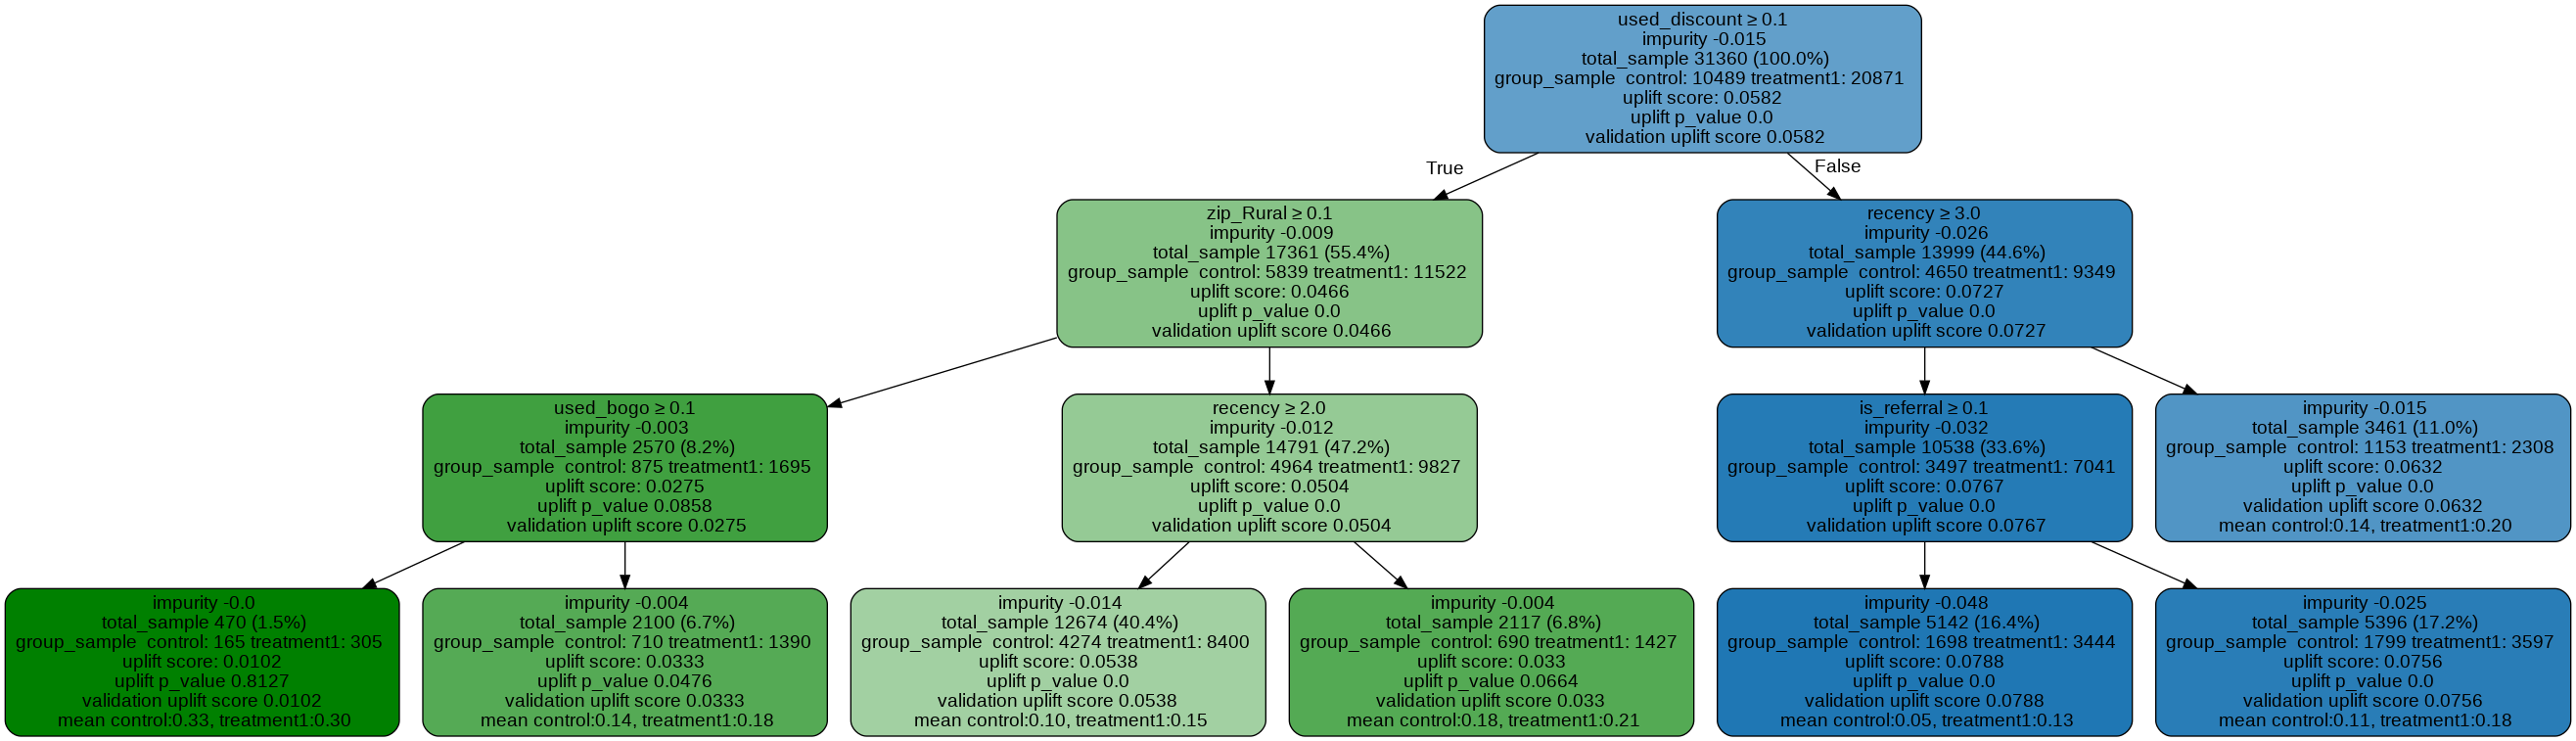

In [82]:
uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

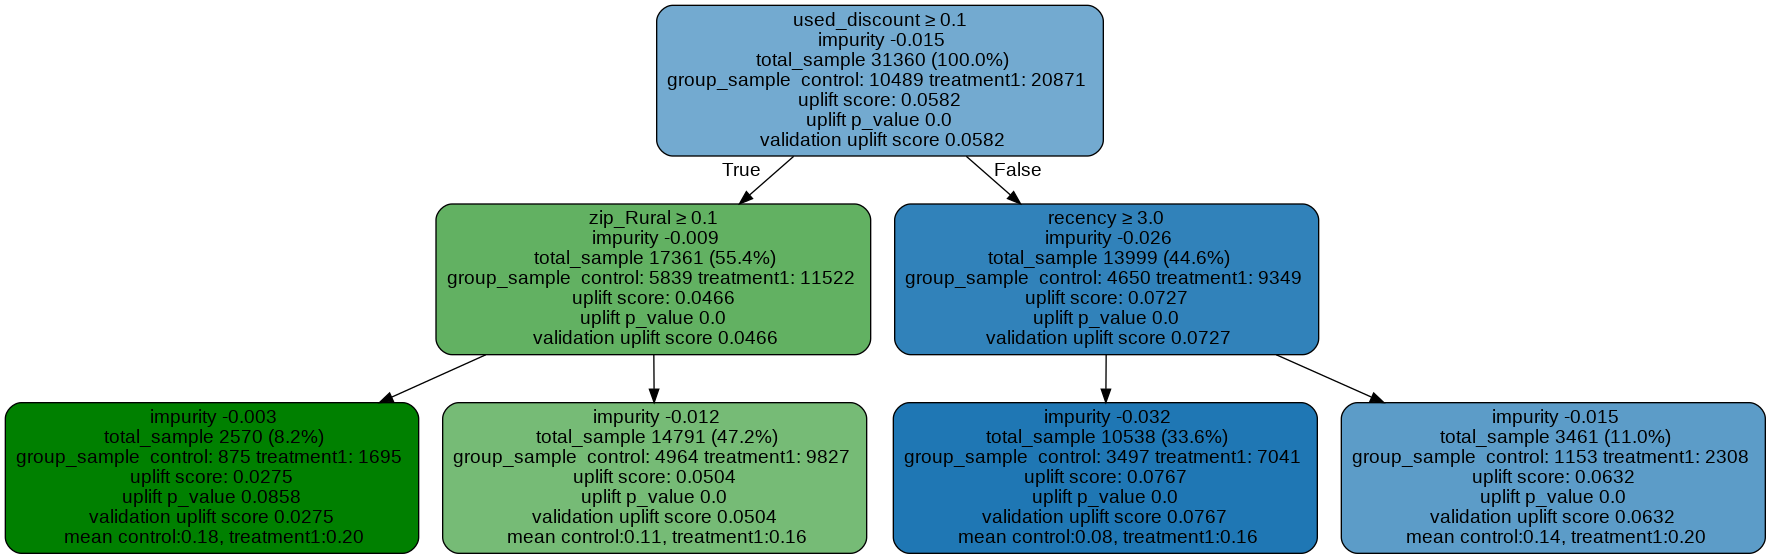

In [83]:
uplift_model = UpliftTreeClassifier(max_depth=3, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Самый левый лист - 2570 человек, которые использовали скидку и у которых zip-code Rural. Им нельзя звонить! 

У всех остальных p_value = 0, это означает, что они положительно реагируют на взаимодействия с ними.